# Imports 

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [8]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length'],
        num_rows: 72134
    })
})


## Split dataset

In [9]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

       label  has_quotes  has_url  percent_uppercase  frequency_punctuation  \
0          1           0        1           3.188750                    182   
1          1           0        0           4.347826                      1   
2          1           0        0           2.314815                      2   
3          0           0        1           3.071161                    154   
4          1           0        1           6.419624                     42   
...      ...         ...      ...                ...                    ...   
72129      0           0        1           3.801170                    105   
72130      1           0        1           3.302146                     51   
72131      0           1        0           3.666201                     85   
72132      0           0        1           3.704801                     73   
72133      1           0        0           3.945428                     62   

       percent_whitespace  frequency_words_length_1

In [10]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_punctuation  \
22156           1        1           4.200000                     78   
46603           0        1          10.169492                     11   
22381           0        1           5.925030                     32   
13489           0        1           4.518848                     86   
40644           0        1           2.686404                     30   
...           ...      ...                ...                    ...   
12895           0        1           3.796928                     38   
60960           0        1           6.216216                     12   
6012            0        1           3.363914                     40   
63107           0        1           3.407657                     45   
6558            0        0           5.263158                      8   

       percent_whitespace  frequency_words_length_15  \
22156           15.500000                          0   
46603            0.0000

### Training

no further preprocessing

In [11]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

Convert Negative values to 0 and scale features to [0,1]

In [12]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Initialize and train multinomialNB classifier

In [13]:
nb_multinomial = MultinomialNB()
nb_multinomial.fit(x_train_scaled, y_train)

MultinomialNB()

In [16]:
# Make predictions
y_pred = nb_multinomial.predict(x_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.6368614403548901


In [18]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.48      0.56      7030
           1       0.61      0.79      0.69      7397

    accuracy                           0.64     14427
   macro avg       0.65      0.63      0.63     14427
weighted avg       0.65      0.64      0.63     14427



In [19]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[3365 3665]
 [1574 5823]]


## Visualize feature importance

examine log probabilities for naive Bayes

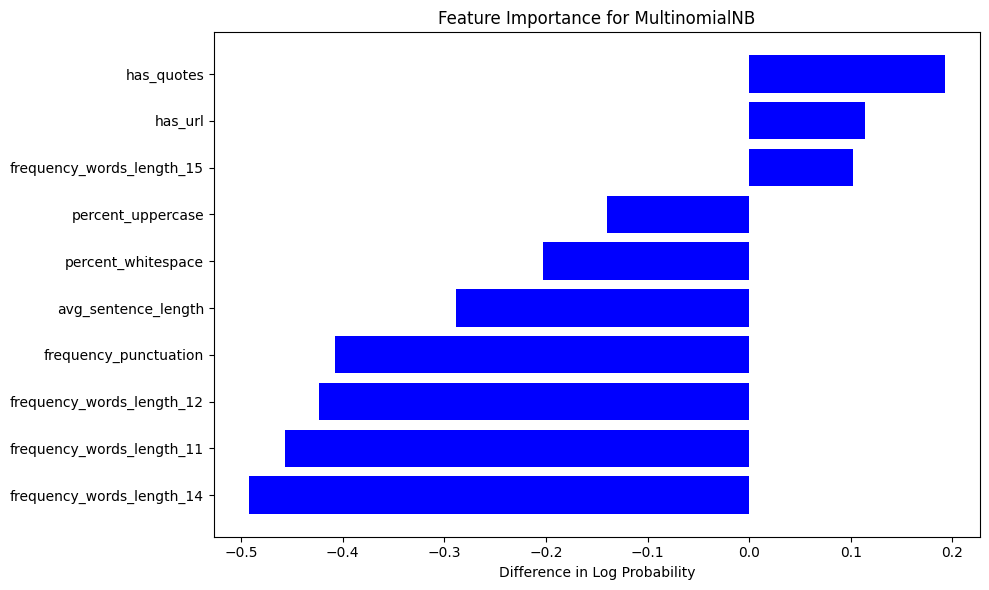

In [21]:
feature_importance = nb_multinomial.feature_log_prob_[1] - nb_multinomial.feature_log_prob_[0]
feature_names = x_train.columns

# Sort features by importance
indices = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.title('Feature Importance for MultinomialNB')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Difference in Log Probability')
plt.tight_layout()
plt.show()

## Tuning alpha parameter with cross-validation

In [22]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Set up GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring='accuracy')

Compare the parameters

In [23]:
# Print best parameters
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))


Best parameters found:  {'alpha': 10.0}
Best cross-validation accuracy: 0.6426


Evaluate model with best parameters

In [24]:
best_nb = grid_search.best_estimator_
y_pred_best = best_nb.predict(x_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy with best parameters: {:.4f}".format(accuracy_best))

Test accuracy with best parameters: 0.6372
